In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

from utils.plotters import plot_solution
from utils.data_loaders import read_solution
from utils.models import Customer, Route, RunningSheet
from utils.log import LoggerFactory, NoLoggerFactory, BaseLoggerFactory

from aco.colony import Colony


## [1] Load Data

In [2]:
SOLUTION = read_solution('data/raw/sintef_routes.txt')
locations = pd.read_csv('data/processed/c101.csv')
solution_locations = np.sum([len(route) for _, route in SOLUTION.items()])
print(f"Number of Locations in Customers[{len(locations)}], Solution[{solution_locations}]")
locations.head()

Number of Locations in Customers[101], Solution[100]


,Unnamed: 0,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
0,0,1,40.0,50.0,0.0,0.0,1236.0,0.0
1,1,2,45.0,68.0,10.0,912.0,967.0,90.0
2,2,3,45.0,70.0,30.0,825.0,870.0,90.0
3,3,4,42.0,66.0,10.0,65.0,146.0,90.0
4,4,5,42.0,68.0,10.0,727.0,782.0,90.0


In [3]:
""" Descriptive Statistics of the Customers.
iloc[1:] is used to exclude the depot from the statistics.
"""
locations.iloc[1:].describe()

,Unnamed: 0,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,50.500000,51.500000,42.300000,48.590000,18.100000,426.800000,487.560000,90.0
std,29.011492,29.011492,22.977591,21.367915,10.415121,282.203738,282.053198,0.0
min,1.000000,2.000000,0.000000,5.000000,10.000000,10.000000,67.000000,90.0
25%,25.750000,26.750000,25.000000,32.000000,10.000000,177.500000,237.750000,90.0
50%,50.500000,51.500000,40.000000,47.500000,10.000000,417.500000,480.000000,90.0
75%,75.250000,76.250000,58.500000,66.000000,20.000000,645.500000,710.000000,90.0
max,100.000000,101.000000,95.000000,85.000000,50.000000,1054.000000,1127.000000,90.0


## [1.1] Optimal Solution

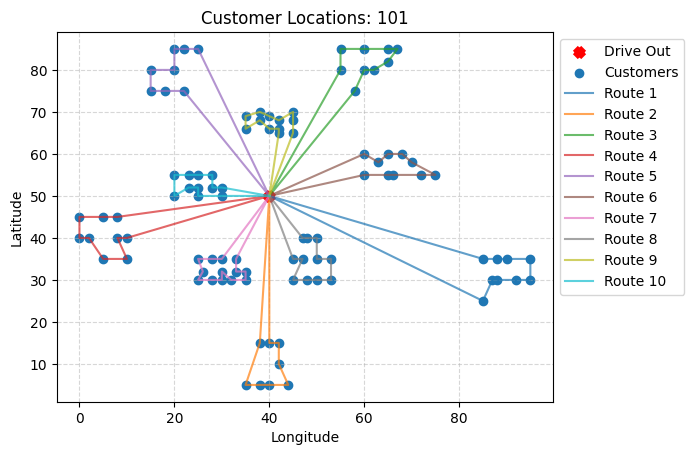

In [4]:
plot_solution(locations, SOLUTION)

## [2] Preprocessing

### [2.1] Remove origin
This dataset consists of 100 customers. But as you can see above, we currently have 101 rows. This is because the first index is the 'Driveout' location / 'Origin'. Thus, we need to remove this from the customers_data.

In [5]:
origin = locations.iloc[0]

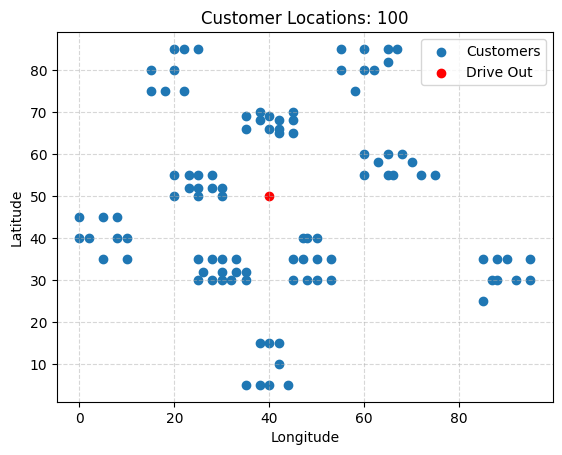

In [6]:
plt.title(f'Customer Locations: {len(locations) - 1}')
plt.scatter(locations.iloc[1:]['Lng'], locations.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## [3] Problem

**REFERENCES**

Mirjalili, Ali, *Youtube*, https://www.youtube.com/watch?v=783ZtAF4j5g
(Cannot use graphs, must use matrixes for the mathematical modelling)[11:30]

• Depot: The starting and ending point for all vehicles. 
• Customers: Each customer has a location, a demand for goods, a time window for 
receiving the delivery, and a service time. 
• Vehicles:  Each  vehicle  has  a  limited  capacity  and  must  return  to  the  depot  after 
completing its route. 

### [3.1] Constraints
1. Each customer is visited exactly once by one vehicle. 
2. Deliveries occur within the specified time windows. 
3. The total demand on any route does not exceed the vehicle's capacity.

In [12]:
logger_factory = NoLoggerFactory()
sheet = RunningSheet.from_pd(locations, logger_factory)
colony = Colony(sheet, logger_factory)
vehicles = colony.optimize(N_ITER=100, N_VEHICLES=10, CAPACITY=200, ALPHA=1.0, BETA=0.4, TAU=1.0, Q=1.0, P=0.8)

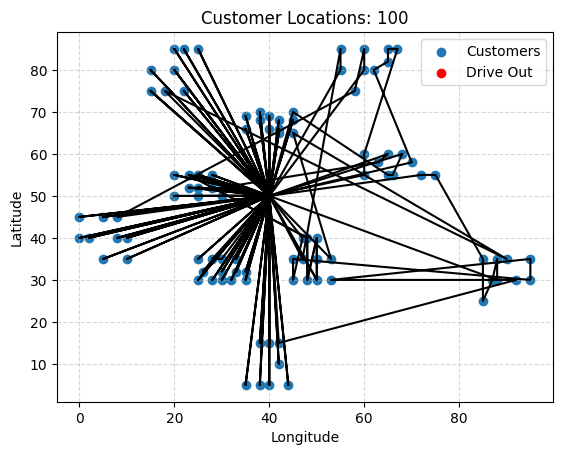

In [13]:
plt.title(f'Customer Locations: {len(locations) - 1}')
plt.scatter(locations.iloc[1:]['Lng'], locations.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

for vehicle in vehicles:
    lats = [sheet.depot.lat] + [b.to_customer.lat for b in vehicle.get_route()]
    lngs = [sheet.depot.lng] + [b.to_customer.lng for b in vehicle.get_route()]
    plt.plot(lngs, lats, color='black')

plt.plot(lngs, lats, color='black')

plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Ant move to node probability formula
**We should set allowed to only be the most near neighbours**

$$P_{ij}(t) =\frac{[\tau_{ij}(t)]^\alpha * [n_{ij}]^\beta}{\sum_{k \in allowed}[\tau_{ik}(t)]^\alpha * [n_{ik}]^\beta}$$